# Budowa modelu - część 2


In [4]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import wordnet
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
import nltk
import gensim.downloader as api

# from transformers import BertTokenizer, BertModel
# import torch
# from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

## Wczytanie danych
<font color='green'>Uwaga dla zespołu walidacyjnego - przy każdej operacji dla danych treningowych został dodany zakomentowany kod dla danych walidacyjnych. Wystarczy odkomentować odpowiednią linię, aby zastosować operację na danych walidacyjnych.</font>

Załadujmy i przekształcmy dane zgodnie z krokiem pierwszym budowy.

In [5]:
df_train = pd.read_csv('data\\X_train.csv')
# df_valid = pd.read_csv('data\\X_valid.csv')

In [6]:
# obróbka danych z kroku 1
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Mapowanie tagów części mowy z biblioteki NLTK na format używany przez WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_tokens(tokens):
    """Lematyzacja tokenów"""
    tokens = word_tokenize(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    return ' '.join(lemmatized_tokens)

def clean_text(text):
    stopwords_set = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    words = [word for word in tokens if word.isalpha() and word not in stopwords_set]
    return words

def preprocess_data(df):
    df['Cleaned_text'] = df['Text'].apply(lambda x: ' '.join(clean_text(x)))
    df['Lemmatized_text'] = df['Cleaned_text'].apply(lemmatize_tokens)
    df = df.drop(columns=['Cleaned_text'])
    df = df.drop_duplicates(subset='Lemmatized_text', keep="last")
    df = df.reset_index(drop=True)
    return df

Otrzymujemy w ten sposób dane z 2 kolumnami - 'Lemmatized_text' oraz 'Text'. Pierwsza z nich zawiera tekst po lematyzacji, druga to tekst oryginalny. W dalszej części będziemy pracować na kolumnie 'Lemmatized_text'.

In [7]:
df_train = preprocess_data(df_train)    # może to potrwać do 2 minut
# df_valid = preprocess_data(df_valid)

In [8]:
df_train
# df_valid

,Text,Lemmatized_text
0,Double eviction from Big Brother\n \n Model Ca...,double eviction big brother model caprice holb...
1,Ailing EuroDisney vows turnaround\n \n EuroDis...,ail eurodisney vow turnaround eurodisney europ...
2,Japanese growth grinds to a halt\n \n Growth i...,japanese growth grind halt growth japan evapor...
3,Small firms 'hit by rising costs'\n \n Rising ...,small firm rise rise fuel material cost hit co...
4,Mexicans tracking unhappy Juninho\n \n Mexican...,mexican track unhappy juninho mexican outfit r...
...,...,...
1060,February poll claim 'speculation'\n \n Reports...,february poll claim report tony blair planning...
1061,Carry On star Patsy Rowlands dies\n \n Actress...,carry star patsy rowlands dy actress patsy row...
1062,Ferguson puts faith in youngsters\n \n Manches...,ferguson put faith youngster manchester united...
1063,Security warning over 'FBI virus'\n \n The US ...,security warn u federal bureau investigation w...


## Feature Engineering

Ta część polega na przekształceniu tekstu na wektory, które będą podstawą do stworzenia modelu. W tym celu wykorzystamy kilka metod:
- Tf-Idf, która przypisuje wagę słowom w zależności od ich częstości w tekście
- analiza sentymentu, która przypisuje wartość sentymentu do tekstu
- word embeddings (Word2Vec, GloVe, BERT), które przekształcają słowa na wektory
- wykorzystanie bigramów i trigramów, dla których zliczymy częstość występowania

### Tf-Idf

In [31]:
tfidf = TfidfVectorizer(max_features=5000, max_df=0.95, min_df=2)
tfidf_features = tfidf.fit_transform(df_train['Lemmatized_text'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())

# tfidf_features_valid = tfidf.fit_transform(df_valid['Lemmatized_text'])
# tfidf_df_valid = pd.DataFrame(tfidf_features_valid.toarray(), columns=tfidf.get_feature_names_out())

In [10]:
tfidf_features.shape

(1065, 5000)

Mamy 5000 kolumn, co oznacza, że dla każdego tekstu mamy 5000 wartości tf-idf. Zostaną one wykorzystane jako feature do modelu. Każda kolumna odpowiada jednemu słowu, co możemy zobaczyć poniżej. Ta tabela jest bardzo rzadka, ponieważ większość wartości to 0.

In [11]:
tfidf_df.loc[:10, 'ability':'bought']

,ability,able,abolish,abortion,abortionist,abroad,absence,absent,absolute,absolutely,...,borrowing,bortolami,bos,boss,boston,bosvelt,bot,bottle,bottom,bought
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.070829,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Analiza sentymentu

In [12]:
sentiment = np.array(df_train['Lemmatized_text'].apply(lambda x: TextBlob(x).sentiment.polarity))

# sentiment_valid = np.array(df_valid['Lemmatized_text'].apply(lambda x: TextBlob(x).sentiment.polarity))

In [13]:
sentiment

array([ 0.1173913 ,  0.00021645, -0.01043103, ...,  0.01666667,
       -0.08888889,  0.01611111])

Mamy utworzoną macierz sentiment, która zawiera wartość sentymentu dla danego tekstu. Jest to wartość z przedziału [-1, 1], gdzie -1 oznacza negatywny sentyment, 0 neutralny, a 1 pozytywny. Wartości te będą wykorzystane jako dodatkowy feature. Zostało to policzone na podstawie biblioteki TextBlob, która oferuje wcześniej wytrenowany model do analizy sentymentu.

### Word embeddings

#### Word2Vec

In [14]:
# to może zająć nawet kilka minut
word2vec_model = api.load('word2vec-google-news-300')

In [15]:
def get_document_vector(doc, embeddings, size=300):
    tokens = doc.lower().split()
    word_vectors = [embeddings[word] for word in tokens if word in embeddings]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(size)

In [16]:
df_train['word2vec_vector'] = df_train['Lemmatized_text'].apply(lambda x: get_document_vector(x, word2vec_model, size=300))
word2vec_features = np.vstack(df_train['word2vec_vector'].values)

# df_valid['word2vec_vector'] = df_valid['Lemmatized_text'].apply(lambda x: get_document_vector(x, word2vec_model, size=300))
# word2vec_features_valid = np.vstack(df_valid['word2vec_vector'].values)

Mamy teraz dodaną kolumnę 'word2vec_vector', która zawiera wektory dla danego tekstu. Przekształciliśmy listę wartości z kolumny 'word2vec_vector' na macierz, która będzie wykorzystana jako feature do modelu.

In [17]:
word2vec_features

array([[ 0.00306091,  0.00465652,  0.00654831, ..., -0.04730461,
         0.01187668,  0.01363922],
       [ 0.02214459,  0.02605987, -0.01730832, ...,  0.0047211 ,
         0.0380854 , -0.05894021],
       [ 0.01710917,  0.04411251, -0.04693774, ...,  0.01571575,
         0.05804446, -0.0584193 ],
       ...,
       [ 0.01507443,  0.04034149,  0.04722635, ..., -0.06183003,
         0.02424897, -0.0072996 ],
       [ 0.02335922, -0.03462372,  0.03324249, ..., -0.12919861,
        -0.0253421 , -0.00698456],
       [ 0.0210643 , -0.01491611, -0.02175508, ...,  0.04037195,
         0.03057884, -0.11797617]], dtype=float32)

#### GloVe

In [18]:
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# niezbędny jest poniższy plik to działania
glove_file = 'data\\glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

In [19]:
df_train['glove_vector'] = df_train['Lemmatized_text'].apply(lambda x: get_document_vector(x, glove_embeddings))
glove_features = np.vstack(df_train['glove_vector'].values)

# df_valid['glove_vector'] = df_valid['Lemmatized_text'].apply(lambda x: get_document_vector(x, glove_embeddings))
# glove_features_valid = np.vstack(df_valid['glove_vector'].values)

In [20]:
glove_features

array([[ 0.08144929,  0.11788537,  0.06032618, ..., -0.03660058,
        -0.19648752,  0.08486496],
       [-0.02217419, -0.00393093, -0.02789216, ..., -0.16036083,
        -0.03527465, -0.03834458],
       [-0.02289726,  0.06763995, -0.06808821, ..., -0.14792182,
        -0.03504488, -0.02487861],
       ...,
       [ 0.04027191,  0.30135107, -0.04405627, ..., -0.267132  ,
        -0.09171909,  0.000694  ],
       [-0.24750851,  0.05435208, -0.10944935, ..., -0.06874712,
        -0.14671089, -0.17064331],
       [-0.03290494,  0.09478553, -0.11004038, ..., -0.09020519,
         0.00674124, -0.05310985]], dtype=float32)

Analogicznie jak dla Word2Vec, mamy teraz dodaną kolumnę 'glove_vector', która zawiera wektory dla danego tekstu. Przekształciliśmy listę wartości z kolumny 'glove_vector' na macierz, która będzie wykorzystana jako feature do modelu.

#### BERT

In [21]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
# def get_bert_embedding(text):
#     inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
#     print("after tokenization")
#     outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

In [22]:
# text = df_train['Lemmatized_text'].values.tolist()

In [23]:
# inputs = tokenizer(text[:40], return_tensors='pt', truncation=True, padding=True, max_length=512)
# 
# input_ids = inputs["input_ids"]
# token_type_ids = inputs["token_type_ids"]
# attention_mask = inputs["attention_mask"]
# BATCH_SIZE = 1
# outputs = []
# for batch in tqdm(range(input_ids.shape[0]//BATCH_SIZE)):
#     outputs.append(model(
#         input_ids=input_ids[batch* BATCH_SIZE: (batch+1) * BATCH_SIZE],
#         token_type_ids=token_type_ids[batch* BATCH_SIZE: (batch+1) * BATCH_SIZE],
#         attention_mask=attention_mask[batch* BATCH_SIZE: (batch+1) * BATCH_SIZE]
#     ))

Niestety BERT wymaga zbyt dużych zasobów pamięciowych jak i obliczeniowych dlatego nie jesteśmy w stanie jej zastosować na naszym sprzęcie. W związku z tym nie będziemy wykorzystywać tej metody w dalszej części.

### Bigramy i trigramy

In [24]:
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=1000)
ngram_matrix = vectorizer.fit_transform(df_train['Lemmatized_text'].to_list())
ngram_df = pd.DataFrame(ngram_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# ngram_matrix_valid = vectorizer.fit_transform(df_valid['Lemmatized_text'].to_list())
# ngram_df_valid = pd.DataFrame(ngram_matrix_valid.toarray(), columns=vectorizer.get_feature_names_out())

In [25]:
ngram_df

,ac milan,academy award,accord report,accord research,account deficit,accuse mr,aer lingus,affair spokesman,air deccan,alan milburn,...,year also,year earlier,year first,year however,year make,year mr,year oscar,year say,young people,young player
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1062,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


W ten sposób otrzymaliśmy macierz z bigramami i trigramami. Została ona przekształcona na DataFrame, który będzie wykorzystany jako feature do modelu. Musimy pamiętać, że ta macierz jest bardzo rzadka, ponieważ większość wartości to 0.

## Normalizacja danych

Niezwykle ważnym krokiem w budowie modelu jest normalizacja danych. W naszym przypadku znormalizujemy dane tf-idf, word2vec, glove oraz bigramy i trigramy. Normalizacja polega na przeskalowaniu danych w taki sposób, aby miały średnią 0 oraz wariancję 1.

In [26]:
scaler = StandardScaler(with_mean=False)

In [27]:
scaler.fit(tfidf_features)
tfidf_features = scaler.transform(tfidf_features).toarray()

scaler.fit(sentiment.reshape(-1, 1))
sentiment = scaler.transform(sentiment.reshape(-1, 1))

scaler.fit(word2vec_features)
word2vec_features = scaler.transform(word2vec_features)

scaler.fit(glove_features)
glove_features = scaler.transform(glove_features)

scaler.fit(ngram_matrix)
ngram_matrix = scaler.transform(ngram_matrix).toarray()

#tfidf_features_valid = scaler.transform(tfidf_features_valid)
#sentiment_valid = scaler.transform(sentiment_valid)
#word2vec_features_valid = scaler.transform(word2vec_features_valid)
#glove_features_valid = scaler.transform(glove_features_valid)
#ngram_matrix_valid = scaler.transform(ngram_matrix_valid).toarray()

In [33]:
tfidf_features.shape, sentiment.shape, word2vec_features.shape, glove_features.shape, ngram_matrix.shape

((1065, 5000), (1065, 1), (1065, 300), (1065, 300), (1065, 1000))

In [34]:
type(tfidf_features), type(sentiment), type(word2vec_features), type(glove_features), type(ngram_matrix)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

## Połączenie utworzonych feature

In [35]:
features = np.concatenate([tfidf_features, sentiment, word2vec_features, glove_features, ngram_matrix], axis=1)

In [36]:
features.shape

(1065, 6601)

Połączyliśmy wszystkie feature w jedną macierz, która będzie wykorzystana do stworzenia modelu. Mamy teraz 6301 kolumn, co oznacza, że dla każdego tekstu mamy 6301 wartości. Zostały one przeskalowane i gotowe do dalszej analizy.

## PCA

Aby zredukować wymiarowość danych, zastosujemy PCA. Pozwoli to na zmniejszenie ilości kolumn, co znacznie przyspieszy proces trenowania modelu. Zależy nam na wybraniu tych składowych, które wyjaśniają 80% wariancji.

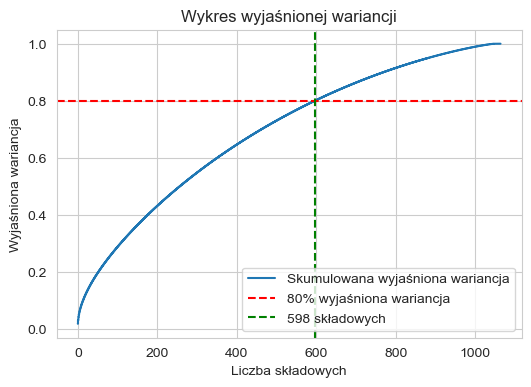

In [37]:
pca = PCA()
pca.fit(features)

variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance)
num_components = np.argmax(cumulative_variance >= 0.80) + 1

plt.figure(figsize=(6, 4))
plt.step(range(len(cumulative_variance)), cumulative_variance, where='mid', label='Skumulowana wyjaśniona wariancja')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% wyjaśniona wariancja')
plt.axvline(x=num_components-1, color='g', linestyle='--', label=f'{num_components} składowych')
plt.xlabel('Liczba składowych')
plt.ylabel('Wyjaśniona wariancja')
plt.legend(loc='best')
plt.title('Wykres wyjaśnionej wariancji')
plt.show()

In [38]:
pca = PCA(n_components=num_components)
pca = pca.fit(features)
features_reduced = pca.transform(features)

# features_reduced_valid = pca.transform(features_valid)

In [39]:
features_reduced.shape

(1065, 598)

Po zastosowaniu PCA otrzymaliśmy 598 składowych, które wyjaśniają 80% wariancji. Zostały one przekształcone na macierz, która będzie wykorzystana jako feature do modelu.

## Określenie liczby klastrów

Teraz określimy optymalną liczbę klastrów korzystając z elbow method oraz silhouette score. Pierwsza metoda polega na wyznaczeniu punktu przegięcia na wykresie wariancji w zależności od liczby klastrów. Druga metoda polega na obliczeniu średniej odległości między klastrami.

In [40]:
def optimal_number_of_clusters(matrix, max_k):
    iters = range(2, max_k+1, 1)
    sse = []
    silhouette_scores = []
    for k in iters:
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(matrix)
        sse.append(model.score(matrix) * -1)
        score = silhouette_score(matrix, model.labels_)
        silhouette_scores.append(score)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(iters, sse, marker='o')
    ax1.set_xlabel('Cluster Centers')
    ax1.set_xticks(iters)
    ax1.set_xticklabels(iters)
    ax1.set_ylabel('SSE')
    ax1.set_title('Elbow Method')

    ax2.plot(iters, silhouette_scores, marker='o')
    ax2.set_xlabel('Cluster Centers')
    ax2.set_xticks(iters)
    ax2.set_xticklabels(iters)
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score')

    plt.show()

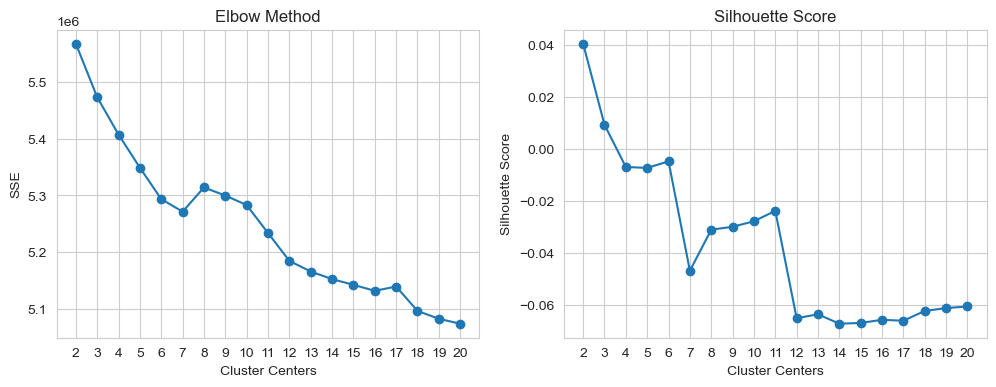

In [41]:
warnings.filterwarnings('ignore')
optimal_number_of_clusters(features_reduced, 20)

Jest to wstępna wersja analizy, która pozwala nam na określenie optymalnej liczby klastrów. Wykres wygląda dość nieoczekiwanie, jednak wydaje nam się że 6 klastrów będzie najlepszą opcją. Ewentualnie można rozważyć 8 klastrów. Dalej spróbujemy jeszcze raz przeprowadzić PCA aby dostać mniej składowych i zobaczyć czy wyniki się zmienią.

In [42]:
pca = PCA(n_components=400)
pca = pca.fit(features)
features_reduced2 = pca.transform(features)

# features_reduced2_valid = pca.transform(features_valid)

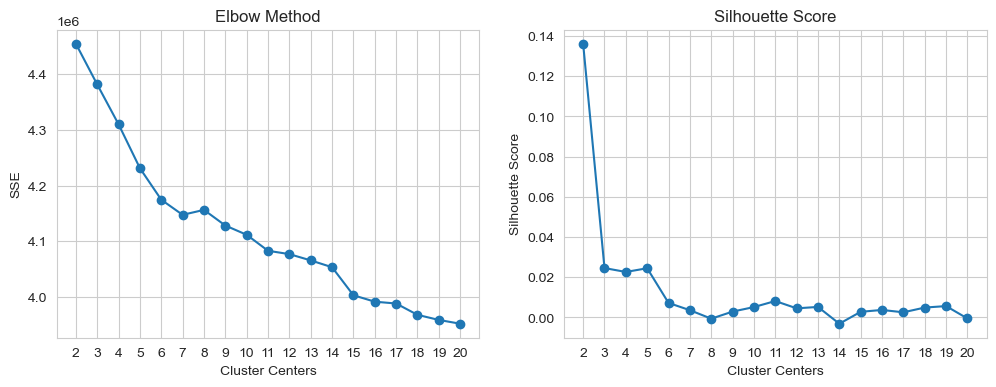

In [43]:
optimal_number_of_clusters(features_reduced2, 20)

Po przeprowadzeniu PCA z mniejszą ilością składowych, wykres wygląda bardziej sensownie. Ostatecznie wybierzemy 5 klastrów jako optymalną liczbę.